In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.losses import MeanSquaredError
from tensorflow import optimizers
from tensorflow import metrics

import requests
import io
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

<h1 align="center">欄位介紹</h1>

| X6   | X7  |X8  |X9  |X10  |
|:----: | :----:  | :----:  | :----:  | :----:  |
| 溫度1床材 | 溫度2爐下 | 溫度3爐中下 | 溫度4爐中上 | 溫度5爐上 |

| Y1   | Y2  |Y3  |Y4  |Y5  |
|:----: | :----:  | :----:  | :----:  | :----:  |
| O2 % | CO2 % | CO_6% O2 (ppm)| NOx_6% O2 (ppm)| SO2 |




In [2]:
data = pd.read_csv(
    io.StringIO(
        requests.get('https://recognise.trendlink.io/model/fbc_demo.csv', verify=False).content.decode('utf-8')
    )
)

In [3]:
# y_return = (data[["Y1","Y2", "Y3", "Y4", "Y5"]].diff(1)/data[["Y1","Y2", "Y3", "Y4", "Y5"]].shift(1)*100)

# y_return_shift_1 = y_return.shift(1)
# y_return_shift_2 = y_return.shift(2)
# y_return_shift_3 = y_return.shift(3)
# y_return_shift_4 = y_return.shift(4)
# y_return_shift_5 = y_return.shift(5)

# data['X11'] = y_return_shift_1['Y1']
# data['X12'] = y_return_shift_1['Y2']
# data['X13'] = y_return_shift_1['Y3']
# data['X14'] = y_return_shift_1['Y4']
# data['X15'] = y_return_shift_1['Y5']

# data['X16'] = y_return_shift_2['Y1']
# data['X17'] = y_return_shift_2['Y2']
# data['X18'] = y_return_shift_2['Y3']
# data['X19'] = y_return_shift_2['Y4']
# data['X20'] = y_return_shift_2['Y5']

# data['X21'] = y_return_shift_3['Y1']
# data['X22'] = y_return_shift_3['Y2']
# data['X23'] = y_return_shift_3['Y3']
# data['X24'] = y_return_shift_3['Y4']
# data['X25'] = y_return_shift_3['Y5']

# data['X26'] = y_return_shift_4['Y1']
# data['X27'] = y_return_shift_4['Y2']
# data['X28'] = y_return_shift_4['Y3']
# data['X29'] = y_return_shift_4['Y4']
# data['X30'] = y_return_shift_4['Y5']

# data['X31'] = y_return_shift_5['Y1']
# data['X32'] = y_return_shift_5['Y2']
# data['X33'] = y_return_shift_5['Y3']
# data['X34'] = y_return_shift_5['Y4']
# data['X35'] = y_return_shift_5['Y5']

# data =data.dropna()

In [4]:
## 測試期間
test_period = 30

## 移動窗格大小
moving_window_size = 360


train_data = data.iloc[:-test_period,:]
test_data = data.iloc[-test_period-moving_window_size:,:]

In [5]:
print('Training X1 : ', train_data['X1'].iloc[0], "~", train_data['X1'].iloc[-1])
print('Testing  X1 : ', test_data['X1'].iloc[moving_window_size-1], "~", test_data['X1'].iloc[-1])

Training X1 :  0 ~ 5340
Testing  X1 :  5340 ~ 5400


In [6]:
x_column_list = [ "X%d"%i for i in range(6, 11) ]
y_column_list = [
#     "Y1",
#     "Y2",
    "Y3",
#     "Y4",
#     "Y5",
]

y_ = 'Y3'

train_y = train_data[y_column_list]
train_x = train_data[x_column_list]

test_y  = test_data[y_column_list]
test_x  = test_data[x_column_list]

# 看一下資料吧

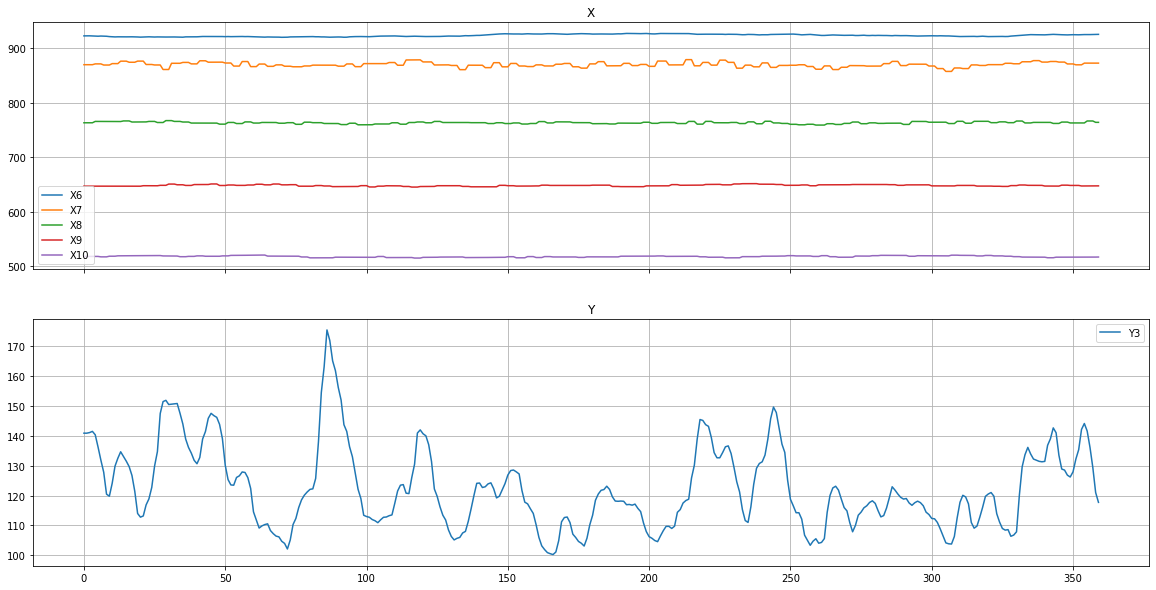

In [8]:
display_data = data.head(moving_window_size)
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(20,10))
ax1.set_title("X")
for i in range(6, 11):
    ax1.plot(display_data['X%d'%i], label = 'X%d'%i) 
ax1.grid(True)
ax1.legend()

ax2.set_title("Y")
ax2.plot(display_data[y_], label = y_)
ax2.grid(True)
ax2.legend()
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler()
x_scaler.fit(train_x) ## 注意這邊是用訓練資料fit

y_scaler = StandardScaler()
y_scaler.fit(train_y) ## 注意這邊是用訓練資料fit


train_x_std = x_scaler.transform(train_x)
test_x_std = x_scaler.transform(test_x)

train_y_std = y_scaler.transform(train_y)
test_y_std = y_scaler.transform(test_y)

In [10]:
def makeMovingWindowData(x, y, moving_window_size):
    """
    提供 x, y, moving_window_size
    
    會回傳 移動窗格整理過後的 x, y
    return => x_window, y_window
    """
    x_window = [] 
    y_window = []  

    #y = y.reshape(1, -1)[0]
    for i in range(moving_window_size, x.shape[0]):
        x_window.append(x[i - moving_window_size: i])
        y_interval_std = y[i - moving_window_size: i].std()
        y_window.append([y[i] - y_interval_std*2, y[i], y[i] + y_interval_std*2])
    x_window = np.array(x_window)
    y_window = np.array(y_window)

    return x_window, y_window

In [11]:
train_x_window , train_y_window = makeMovingWindowData(
    train_x_std, train_y_std, moving_window_size
)

train_y_window = train_y_window.reshape((train_y_window.shape[0], train_y_window.shape[1]))

test_x_window , test_y_window = makeMovingWindowData(
    test_x_std, test_y_std, moving_window_size
)

test_y_window = test_y_window.reshape((test_y_window.shape[0], test_y_window.shape[1]))

In [12]:
train_x_len, train_window_size, train_freature_count = train_x_window.shape

print('訓練資料長度 : ', train_x_len )
print('移動窗格大小 : ', train_window_size)
print('特徵長度    : ', train_freature_count)

訓練資料長度 :  2311
移動窗格大小 :  360
特徵長度    :  5


In [13]:
# # No GPU found

# import os
# import tensorflow as tf

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# if tf.test.gpu_device_name():
#     print('GPU found')
# else:
#     print("No GPU found")

In [14]:
# 第一版

model = Sequential()
# 加入輸入層 LSTM 
model.add(LSTM(
    units = 40, 
    return_sequences = True, 
    input_shape = (train_window_size, train_freature_count),
    activation='relu'))
# 加入Dropout層 
model.add(Dropout(0.3))

# 加入第二層 LSTM 
model.add(LSTM(units = 80, activation='tanh', return_sequences = True))
# 加入Dropout層 
model.add(Dropout(0.3))

# 加入第二層 LSTM 
model.add(LSTM(units = 80, activation='tanh', return_sequences = True))
# 加入Dropout層 
model.add(Dropout(0.3))

# 加入第三層 LSTM 
model.add(LSTM(units = 40, activation='tanh'))
# 加入Dropout層 
model.add(Dropout(0.3))

# 最後輸出層
model.add(Dense(units = train_y_window.shape[-1]))

# model.compile(optimizer = 'adam', loss = 'mse')
model.compile(loss= MeanSquaredError(),
            optimizer= "adam",
            metrics=[metrics.MeanAbsoluteError()])

2021-10-15 10:42:55.216390: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-15 10:42:55.216468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mycena-CV): /proc/driver/nvidia/version does not exist


In [15]:
train_history = model.fit(
    train_x_window,
    train_y_window,
    epochs = 100,
    batch_size=160,
    verbose=1
)

2021-10-15 10:43:10.467744: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
15/15 [==============================] - 24s 1s/step - loss: 1.6062 - mean_absolute_error: 0.9618
Epoch 2/100
15/15 [==============================] - 19s 1s/step - loss: 1.0219 - mean_absolute_error: 0.7582
Epoch 3/100
15/15 [==============================] - 19s 1s/step - loss: 0.9602 - mean_absolute_error: 0.7271
Epoch 4/100
15/15 [==============================] - 19s 1s/step - loss: 0.9747 - mean_absolute_error: 0.7303
Epoch 5/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 6/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 7/100
15/15 [==============================] - 20s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 8/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 9/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 10/100
15/15 [====================

15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 79/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 80/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 81/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 82/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 83/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 84/100
15/15 [==============================] - 20s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 85/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 86/100
15/15 [==============================] - 19s 1s/step - loss: nan - mean_absolute_error: nan
Epoch 87/100
15/15 [==============================] - 19s 1s/step - 

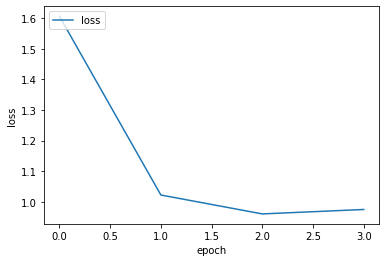

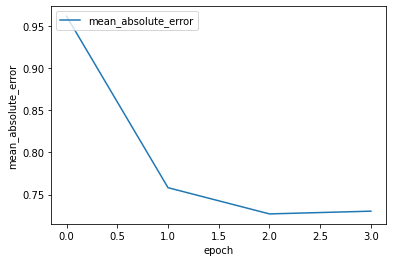

In [16]:
import matplotlib.pyplot as plt

for training_key in train_history.history.keys():
    plt.plot(train_history.history[training_key], label = training_key)
    plt.ylabel(training_key)
    plt.xlabel('epoch')
    plt.legend([training_key], loc='upper left')
    plt.show()

# 進行預測

In [17]:
fr = widgets.FloatRangeSlider(
    value=[5, 7.5],
    min=0,
    max=10.0,
    step=0.1,
    description='Test:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

In [18]:
def handle_slider_change(change):
    print(change)
    
fr.observe(handle_slider_change)
fr

FloatRangeSlider(value=(5.0, 7.5), continuous_update=False, description='Test:', max=10.0, readout_format='.1f…

In [ ]:
test_x_window.shape

In [ ]:
test_x_window

In [ ]:
test_x_window[0]

In [ ]:
plt.figure(figsize=(20,10))
for i in range(6, 11):
    plt.plot(data['X%d'%i], label = 'X%d'%i) 
# plt.plot(testing_y_date, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price') 
plt.legend()
plt.show()

In [ ]:
test_prediction_std = model.predict(test_x_window)

# 還原成y

In [ ]:
test_prediction = y_scaler.inverse_transform(test_prediction_std)
test_y_ = y_scaler.inverse_transform(test_y_window)

# 原始
# test_prediction = test_prediction_std
# test_y_ = test_y_window

In [ ]:
plt.figure(figsize=(20,10))
# plt.plot(np.arange(test_y_.shape[0]), test_prediction[:,0], color = 'red', label = ['pred_%s'%y_ for y_ in y_column_list]) 
plt.plot(np.arange(test_y_.shape[0]), test_y_[:,0], color = 'b', label = y_column_list) 
plt.plot(test_prediction, color = 'red') 
# for the_idx, the_pred_set in enumerate(test_prediction):
#     plt.plot(np.arange(the_idx, the_idx + test_y_.shape[1]), the_pred_set, color = 'brown') 
    
plt.legend()
plt.show()

In [ ]:
# import os

# saved_model_path = 'confidence_output'
# if not os.path.isdir(saved_model_path):
#     os.makedirs(saved_model_path)
    
# # 存檔模型架構
# with open(os.path.join(saved_model_path, f'{saved_model_path}_model_summary.txt'),'w') as writer:
#     model.summary(print_fn=lambda x: writer.write(x + '\n'))
    
# # 將模型儲存至 HDF5 檔案中
# model.save(os.path.join(saved_model_path, f'{saved_model_path}_model.h5'))

In [ ]:
def download_file(url):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True, verify=False) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return local_filename

In [ ]:
print(__doc__)

# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

In [ ]:
regr_1.feature_importances_

In [ ]:
regr_1.